In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import yfinance
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import statsmodels.api as sm
from pmdarima import auto_arima  
from arch import arch_model
from scipy.stats.distributions import chi2
from statsmodels.tsa.stattools import adfuller 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.tools import diff 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.arima_model import ARMA, ARIMA, ARMAResults, ARIMAResults
%matplotlib inline

In [3]:
sns.set_style("whitegrid")

# Data

In [309]:
# Traditional Finance
raw_data = yfinance.download(tickers=["GC=F", "SI=F", "^GSPC", "DX-Y.NYB"], start= "2005-02-01", end="2021-06-02",
                 interval="1d", group_by='ticker', auto_adjust=True, treads=True)

[*********************100%***********************]  4 of 4 completed


In [310]:
df = pd.DataFrame(raw_data['GC=F']['Close'].rename('Gold'))

df['SP500'] = raw_data['^GSPC']['Close']
df['DXY'] = raw_data['DX-Y.NYB']['Close']
df['Silver'] = raw_data['SI=F']['Close']

df['ret_Gold'] = df['Gold'].pct_change(1)*100
df['ret_SP500'] = df['SP500'].pct_change(1)*100
df['ret_DXY'] = df['DXY'].pct_change(1)*100
df['ret_Silver'] = df['Silver'].pct_change(1)*100

df = df.asfreq('D').dropna()

# GARCH Model rolling forecast

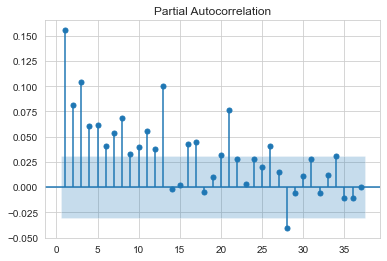

In [217]:
plot_pacf(df['ret_Gold']**2, zero=False);

In [261]:
size = int(len(df)*0.8)

In [262]:
train, test = df[:size], df[size:]

In [263]:
model = arch_model(train['ret_Gold'], vol='garch', p=1, q=1)
result = model.fit(update_freq=5)
result.summary()

Iteration:      5,   Func. Count:     35,   Neg. LLF: 4926.240196525762
Iteration:     10,   Func. Count:     64,   Neg. LLF: 4907.379230878701
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4907.379223492022
            Iterations: 12
            Function evaluations: 73
            Gradient evaluations: 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:               ret_Gold   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4907.38
Distribution:                  Normal   AIC:                           9822.76
Method:            Maximum Likelihood   BIC:                           9847.11
                                        No. Observations:                 3256
Date:                Tue, Jul 06 2021   Df Residuals:                     3255
Time:                        21:13:34   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0390  1.817e-02      2.148  3.171e-02 [3.416e-03,7.463e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0105  5.075e-03      2.076  3.792e-02 [5.873e-04,2.048e-02]
alpha[1]       0.0403  1.149e-02      3.503  4.595e-04 [1.773e-02,6.278e-02]
beta[1]        0.9527  1.303e-02     73.100      0.000     [  0.927,  0.978]
============================================================================

Covariance estimator: robust
"""

In [298]:
rolling_pred = []
for i in range(len(test)):
    train = df[:size+i]
    model = arch_model(train['ret_Gold'], vol='garch', p=1, q=1)
    result = model.fit(disp='off')
    pred = result.forecast(horizon=1)
    rolling_pred.append(pred.variance.values[-1:][0][0])

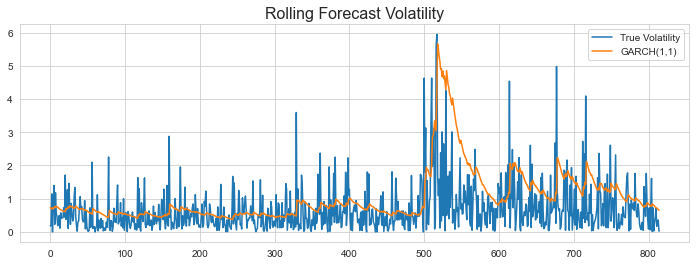

In [299]:
plt.figure(figsize=(12,4));
plt.plot(test['ret_Gold'].abs().reset_index(drop=True), zorder=1);
plt.plot(rolling_pred, zorder=2);
plt.title('Rolling Forecast Volatility', fontsize=16);
plt.legend(['True Volatility', 'GARCH(1,1)']);
#plt.savefig('GARCH.png')

In [300]:
true_vol = test['ret_Gold'].abs().to_numpy()
pred_vol = np.array(rolling_pred)

In [301]:
sum_error = 0
for t,p in zip(true_vol, pred_vol):
    #print(f'true:{t:.5f} predict:{p:.5f}')
    sum_error += (t-p)**2
rmse = np.sqrt(sum_error/len(pred_vol))

In [302]:
rmse

0.9853801737960045

In [303]:
np.corrcoef(true_vol, pred_vol)

array([[1.        , 0.29406468],
       [0.29406468, 1.        ]])

# Forecast n days

In [304]:
n = 7 # n_day predict

In [305]:
model_n = arch_model(df['ret_Gold'], p=3, q=3)
result_n = model_n.fit(disp='off')

In [306]:
result_n.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:               ret_Gold   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5975.65
Distribution:                  Normal   AIC:                           11967.3
Method:            Maximum Likelihood   BIC:                           12017.8
                                        No. Observations:                 4071
Date:                Tue, Jul 06 2021   Df Residuals:                     4070
Time:                        21:30:49   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0357  1.612e-02      2.216  2.671e-02 [4.122e-03,6.731e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0314  1.526e-02      2.060  3.938e-02 [1.530e-03,6.133e-02]
alpha[1]       0.0395  1.759e-02      2.243  2.488e-02 [4.985e-03,7.395e-02]
alpha[2]       0.0412  1.429e-02      2.885  3.908e-03 [1.323e-02,6.924e-02]
alpha[3]       0.0455  1.523e-02      2.986  2.823e-03 [1.563e-02,7.532e-02]
beta[1]        0.0000      0.348      0.000      1.000     [ -0.682,  0.682]
beta[2]    1.2902e-11      0.107  1.210e-10      1.000     [ -0.209,  0.209]
beta[3]        0.8512      0.344      2.476  1.329e-02     [  0.177,  1.525]
============================================================================

Covariance estimator: robust
"""

In [294]:
pred_n = result_n.forecast(horizon=n)
pred_n = pd.Series(pred_n.variance.values[-1,:])

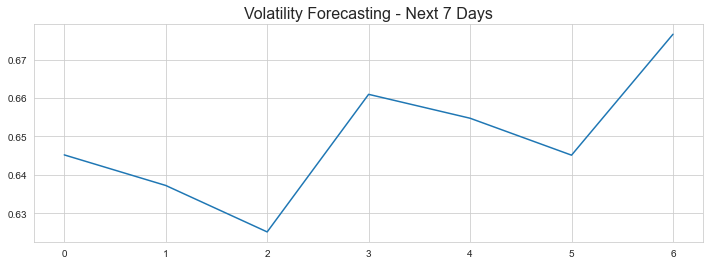

In [295]:
plt.figure(figsize=(12,4))
plt.plot(pred_n)
plt.title('Volatility Forecasting - Next '+str(n)+' Days', fontsize=16);